## Verwendete Libraries / Softwaretools

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import io
import datetime
import requests
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.signal import butter, filtfilt

from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

from astropy.timeseries import TimeSeries

## Aufbereitung der Messdaten Erfurt-Sundhausen

In [2]:
filename ='20_02_to_26_02_Sundhausen to FZE port 2.csv'
skip = 8
sep = ";"

In [3]:
columns = ['Time[date hh:mm:ss] ', ' Elapsed Time [hh:mm:ss:ms]', ' Normalized s 1 ', ' Normalized s 2 ', ' Normalized s 3 ', ' S 0 [mW]', ' S 1 [mW]', ' S 2 [mW]', ' S 3 [mW]', ' Azimuth[°] ', ' Ellipticity[°] ', ' DOP[%] ', ' DOCP[%] ', ' DOLP[%] ', ' Power[mW] ', ' Pol Power[mW] ', ' Unpol Power[mW] ', ' Power[dBm] ', ' Pol Power[dBm] ', ' Unpol Power[dBm] ', ' Power-Split-Ratio ', ' Phase Difference[°] ', ' Warning']
for c in range(len(columns)):
    print(c, ': ', columns[c])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]

0 :  Time[date hh:mm:ss] 
1 :   Elapsed Time [hh:mm:ss:ms]
2 :   Normalized s 1 
3 :   Normalized s 2 
4 :   Normalized s 3 
5 :   S 0 [mW]
6 :   S 1 [mW]
7 :   S 2 [mW]
8 :   S 3 [mW]
9 :   Azimuth[°] 
10 :   Ellipticity[°] 
11 :   DOP[%] 
12 :   DOCP[%] 
13 :   DOLP[%] 
14 :   Power[mW] 
15 :   Pol Power[mW] 
16 :   Unpol Power[mW] 
17 :   Power[dBm] 
18 :   Pol Power[dBm] 
19 :   Unpol Power[dBm] 
20 :   Power-Split-Ratio 
21 :   Phase Difference[°] 
22 :   Warning


In [4]:
angle0 = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[1], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10]])

In [5]:
angle0

,Time[date hh:mm:ss],Elapsed Time [hh:mm:ss:ms],S 0 [mW],S 1 [mW],S 2 [mW],S 3 [mW],Azimuth[°],Ellipticity[°]
0,2025-02-20 13:28:29.46,0.00:00:00:252,0.1935,0.1461,0.027860,0.10750,5.40,17.93
1,2025-02-20 13:28:29.71,0.00:00:00:505,0.1736,0.1780,-0.002731,0.09864,-0.44,14.50
2,2025-02-20 13:28:29.96,0.00:00:00:750,0.1772,0.1765,0.025030,0.09197,4.04,13.64
3,2025-02-20 13:28:30.20,0.00:00:00:999,0.1955,0.1560,0.016250,0.08845,2.97,14.71
4,2025-02-20 13:28:30.45,0.00:00:01:249,0.1794,0.1653,-0.017660,0.11020,-3.05,16.77
...,...,...,...,...,...,...,...,...
2369649,2025-02-27 13:28:38.07,7.00:00:08:863,0.1718,-0.1185,-0.110500,0.07755,-68.49,12.79
2369650,2025-02-27 13:28:38.32,7.00:00:09:111,0.1865,-0.1431,-0.105200,0.06741,-71.84,10.39
2369651,2025-02-27 13:28:38.57,7.00:00:09:360,0.1749,-0.1248,-0.111700,0.07332,-69.09,11.82
2369652,2025-02-27 13:28:38.81,7.00:00:09:605,0.1865,-0.1305,-0.124500,0.07293,-68.17,11.01


In [6]:
angle = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[1], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10]])

In [7]:
angle[columns[0]] = pd.to_datetime(angle[columns[0]])
angle.set_index(columns[0], inplace=True)

In [8]:
angle[columns[5]] = angle[columns[5]].astype(float)

In [9]:
angleAstro = TimeSeries.from_pandas(angle)

In [ ]:
#angleAstro['days']=angleAstro.time.ymdhms.day

In [10]:
angle_daily = angle.groupby(angle.index.date)
angle_daily_list = list(angle_daily)

type(angle_daily_list[0][1])

pandas.core.frame.DataFrame

In [11]:
angleAstro_daily_list = []

for iday in range(0, len(angle_daily_list)):
    angleAstro_daily_list.append(TimeSeries.from_pandas(angle_daily_list[iday][1]))

## Aufbereitung der Wetterdaten

In [22]:
# Erfurt - Latitude: 51.0 & Longitude: 11.0

url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=51.0&longitude=11.0&"
    "start_date=2025-02-20&end_date=2025-02-27&"
    "hourly=temperature_2m,relative_humidity_2m,cloud_cover,wind_speed_10m,wind_direction_10m,rain&"
    "timezone=Europe/Berlin"
)

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    weather = pd.DataFrame(data["hourly"])
    print(weather.head())
else:
    print("Fehler beim Abrufen:", response.status_code)
    print(response.text)

               time  temperature_2m  relative_humidity_2m  cloud_cover  \
0  2025-02-20T00:00            -2.9                    54            0   
1  2025-02-20T01:00            -2.7                    50            0   
2  2025-02-20T02:00            -2.5                    47            0   
3  2025-02-20T03:00            -2.0                    50            0   
4  2025-02-20T04:00            -2.4                    52           11   

   wind_speed_10m  wind_direction_10m  rain  
0             9.5                 143   0.0  
1             9.8                 144   0.0  
2             9.5                 148   0.0  
3            11.6                 159   0.0  
4            11.1                 166   0.0  


In [23]:
units = data['hourly_units']
weather_columns = []
for key, value in units.items():
    weather_columns.append(f'{key} [{value}]')

weather.columns = weather_columns
weather.to_csv("open-meteo_erfurt.csv", index=False)

In [ ]:
sunrise = [
    datetime.datetime.strptime('2025-02-20 07:18:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-21 07:16:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-22 07:14:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-23 07:12:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-24 07:10:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-25 07:08:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-26 07:06:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-27 07:04:00', '%Y-%m-%d %H:%M:%S')
]

sunset =  [
    datetime.datetime.strptime('2025-02-20 17:41:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-21 17:43:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-22 17:44:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-23 17:46:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-24 17:48:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-25 17:50:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-26 17:51:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-27 17:53:00', '%Y-%m-%d %H:%M:%S')
]

In [ ]:
w_data = [
    {"header": "temperature_2m [°C]", "color" : "tab:red", "unit": "°C", "label": "Temperature"},
    {"header": "relative_humidity_2m [%]", "color" : "tab:purple", "unit": "%", "label": "Humidity"},
    {"header": "cloud_cover [%]", "color" : "tab:gray", "unit": "%", "label": "Cloud Cover"},
    {"header": "wind_speed_10m [km/h]", "color" : "tab:green", "unit": "km/h", "label": "Windspeed"},
    {"header": "wind_direction_10m [°]", "color" : "tab:orange", "unit": "°", "label": "Winddirection"},
    {"header": "rain [mm]", "color" : "tab:cyan", "unit": "mm", "label": "Rain"}
]

for i in range(len(w_data)):
    print(f'{i}: {w_data[i]["label"]}')

In [ ]:
weather[weather_columns[0]] = pd.to_datetime(weather[weather_columns[0]])
weather.set_index(weather_columns[0], inplace=True)

## Spectral Analysis

In [12]:
from scipy.signal import lombscargle
from astropy.timeseries import LombScargle
import astropy.units as u
import heapq

In [13]:
def plotTimeEvolution(df_day, ydata, ax, col, iday):
    #ax.figure(figsize = (16,8))
        
    ax.plot(df_day.index, ydata, label=columns[col])
            
    #plt.grid()
    ax.legend(loc = 'best')
    #ax.set_title(f'Applied High Pass Filter of {columns[10]}on {angle_daily_list[i][0]}\n(boxsize={box})')
    ax.set_title(f'Evolution of {columns[col]} on {angle_daily_list[iday][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel(columns[col])
    #ax.show()

In [14]:
def plotSpectralPower(df_day, ydata, ax, col, iday):
    w = np.linspace(0.25, 100, 1000) #2002
    pgram_power_f = lombscargle(df_day.index, ydata, w, normalize=False, floating_mean=True)
            
    #ax.figure(figsize = (16,8))
            
    ax.plot(w, pgram_power_f, label=columns[col])
            
    #plt.grid()
    ax.legend(loc = 'best')
    ax.set_title(f'Spectrum of {columns[col]} on {angle_daily_list[iday][0]}')
    ax.set_xlabel('angular freq')
    ax.set_ylabel(columns[col])
    #ax.show()

In [15]:
def plotSpectralPowerAstro(df_day, ydata, ax, col, iday):
    ls = LombScargle(df_day, ydata)
    
    frequency, power = ls.autopower()

    #three_largest_power_peaks = heapq.nlargest(3, power)
    
    #false_alarm_probs = ls.false_alarm_probability(three_largest_power_peaks, method='bootstrap')

    #print(false_alarm_probs)
            
    #ax.figure(figsize = (16,8))
            
    ax.plot(frequency.to(u.Hz), power, label=columns[col])
            
    #plt.grid()
    ax.legend(loc = 'best')
    ax.set_title(f'{columns[col]} on {angle_daily_list[iday][0]}')
    ax.set_xlabel('1/s')
    ax.set_ylabel(columns[col])
    #ax.show()

In [16]:
def plotTimeOrSpectrum(ax, col, iday, plotTime, plotFreq):
    #df_day = angle_daily_list[iday][1][columns[col]]
    time = angleAstro_daily_list[iday]['time']
    df_day = angleAstro_daily_list[iday][columns[col]]
    ydata = np.array(df_day)
    
    if plotTime == True:
        plotTimeEvolution(df_day, ydata, ax, col, iday)

    if plotFreq == True:
        #plotSpectralPower(df_day, ydata, ax, col, iday)
        time.format = 'cxcsec'
        plotSpectralPowerAstro(time, df_day, ax, col, iday)

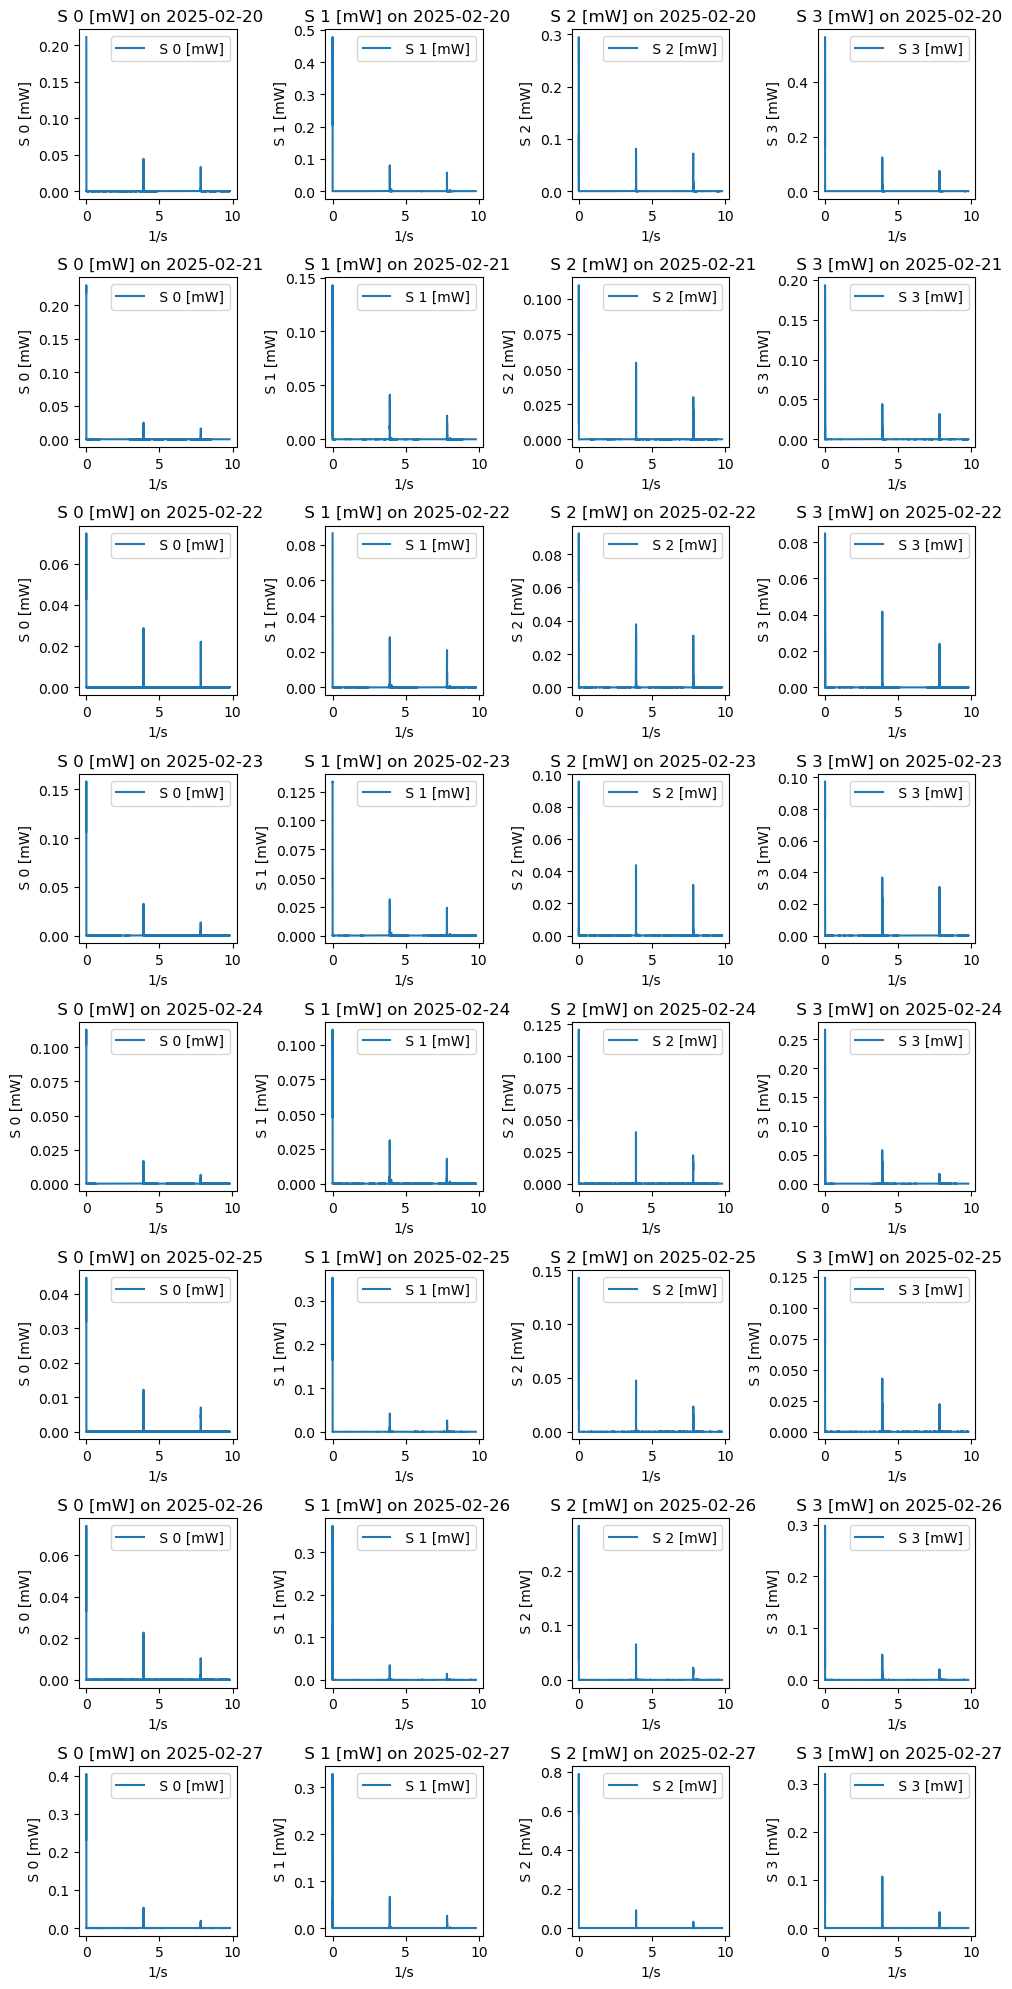

In [24]:
nrDays = len(angle_daily_list)
nrCols = 4
colOffset = 5

fig, axs = plt.subplots(nrDays,nrCols, figsize=(10, 20), sharex=False)

for icol in range(0,nrCols):
    for iday in range(0, nrDays):
        plotTimeOrSpectrum(axs[iday,icol], icol + colOffset, iday, False, True)
#plotTimeOrSpectrum(axs, 0 + colOffset, 0, False, True)

plt.tight_layout()
#plt.show()
plt.savefig('spectral_analysis_erfurt_sundhausen.png', bbox_inches='tight')

## Playground

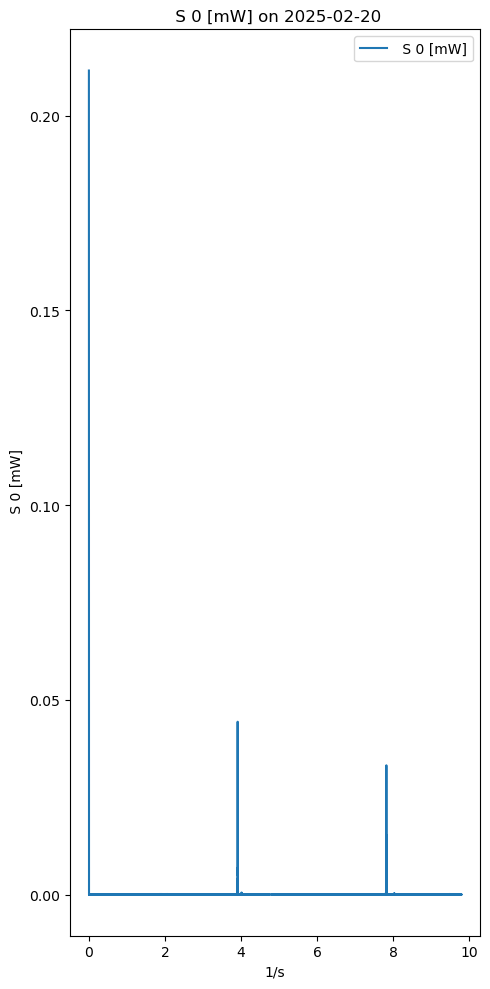

<Figure size 640x480 with 0 Axes>

In [22]:
nrDays = 1 #len(angle_daily_list)
nrCols = 1
colOffset = 5

fig, axs = plt.subplots(nrDays,nrCols, figsize=(5, 10), sharex=False)


plotTimeOrSpectrum(axs, 0 + colOffset, 0, False, True)

plt.tight_layout()
plt.show()
plt.savefig('test.png', bbox_inches='tight')